In [1]:
!pip install -q keras-core
!pip install --upgrade keras_cv tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.2 which is incompatible.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [5]:
!gdown "https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:16<00:00, 180MB/s]


In [6]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]


def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


In [7]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [8]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ get_item (GetItem)        │ (None, 512, 512)       │          0 │ input_layer[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 512, 512)       │          0 │ input_layer[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 512, 512)       │          0 │ input_layer[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ stack (Stack)             │ (None, 512, 512, 3)    │          0 │ get_item[0][0],            │
│                           │                        │            │ get_item_1[0][0],          │
│                           │                        │            │ get_item_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ add (Add)                 │ (None, 512, 512, 3)    │          0 │ stack[0][0]                │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │          0 │ add[0][0]                  │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │      9,472 │ conv1_pad[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │        256 │ conv1_conv[0][0]           │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │          0 │ conv1_bn[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │          0 │ conv1_relu[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │          0 │ pool1_pad[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │      4,160 │ pool1_pool[0][0]           │
│ (Conv2D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │        256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │          0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │     36,928 │ conv2_block1_1_relu[0][0]  │
│ (Conv2D)                  │                        │            │                            │
├──────────────────────

 Total params: 11,857,236 (45.23 MB)

 Trainable params: 11,824,500 (45.11 MB)

 Non-trainable params: 32,736 (127.88 KB)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 165s 453ms/step - accuracy: 0.7389 - loss: 0.8254 - val_accuracy: 0.5789 - val_loss: 9.1209
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 116s 437ms/step - accuracy: 0.7537 - loss: 0.7765 - val_accuracy: 0.0517 - val_loss: 433.4497
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 436ms/step - accuracy: 0.7599 - loss: 0.7543 - val_accuracy: 0.1267 - val_loss: 130.5202
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.7645 - loss: 0.7424 - val_accuracy: 0.5174 - val_loss: 11.7606
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.7729 - loss: 0.7172 - val_accuracy: 0.3655 - val_loss: 19.8494
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 437ms/step - accuracy: 0.7426 - loss: 0.8131 - val_accuracy: 0.6452 - val_loss: 1.3850
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.7716 - loss: 0.7184 - val_accuracy: 0.6392 - val_loss: 1.5619
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 437ms/step - accuracy: 0.

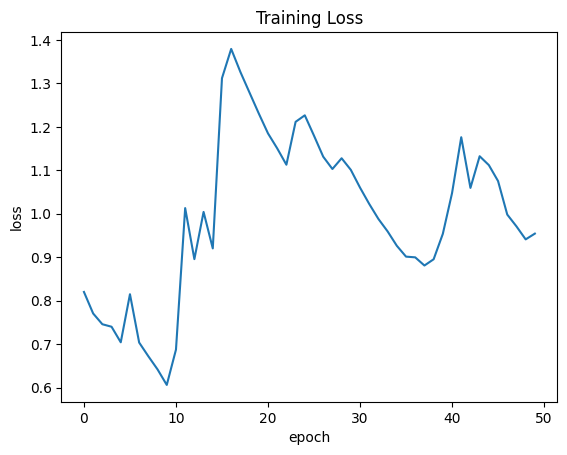

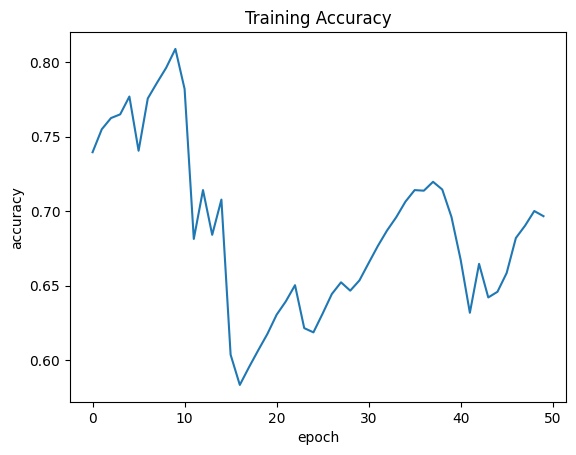

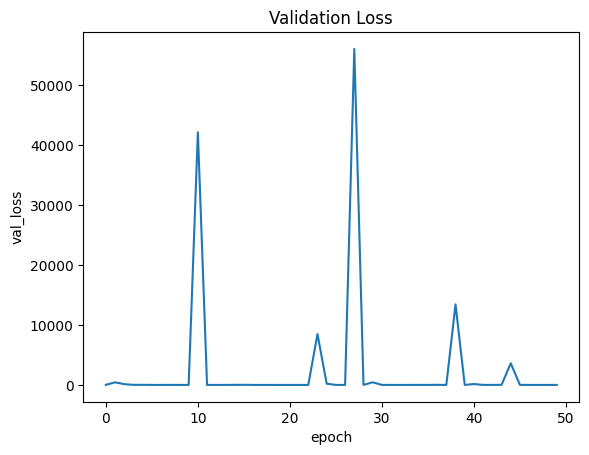

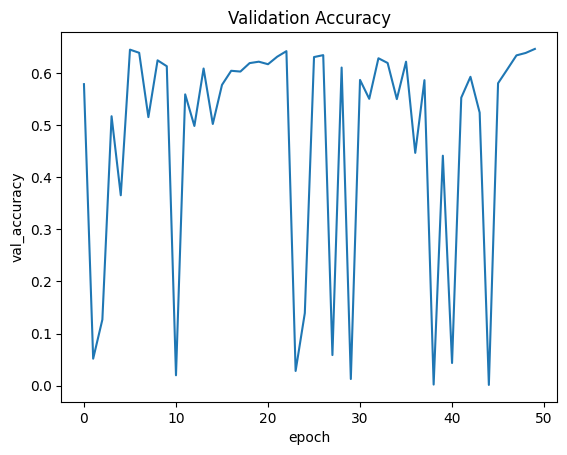

In [12]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [13]:
# Loading the Colormap
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


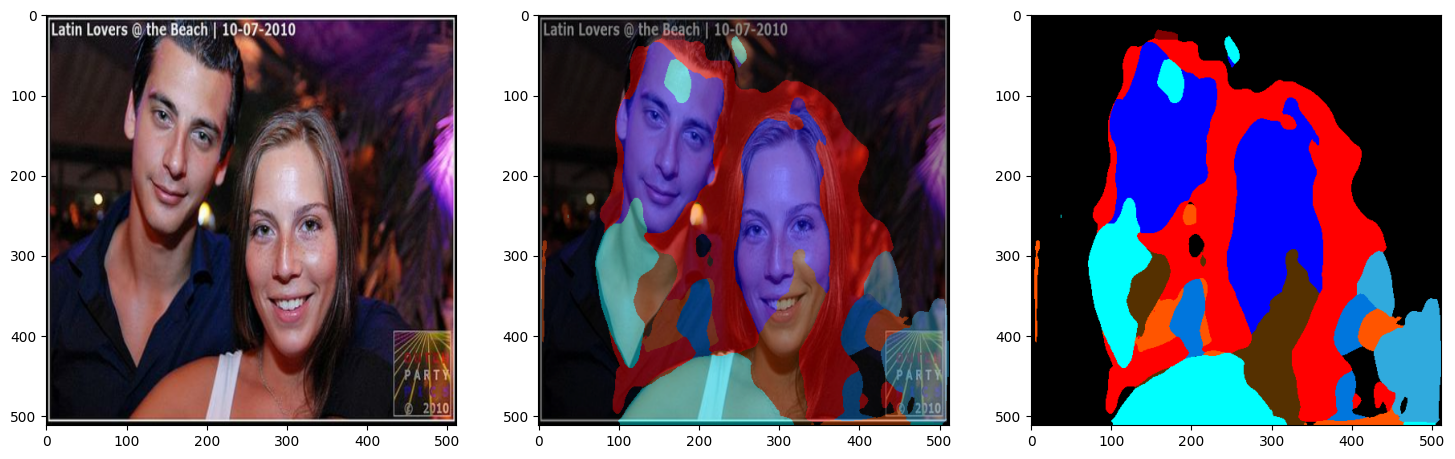

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


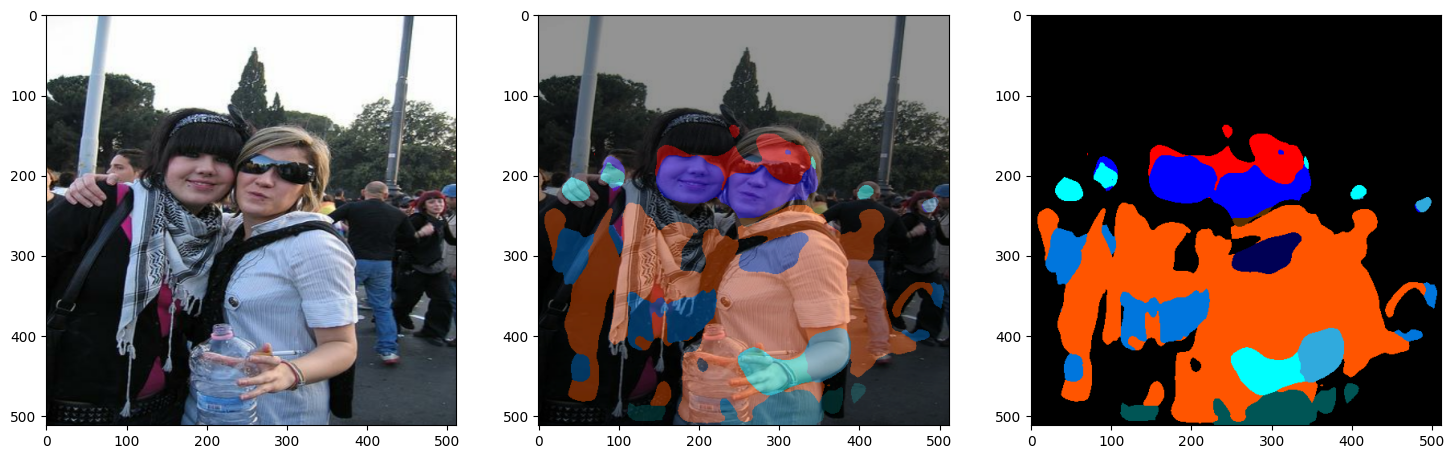

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


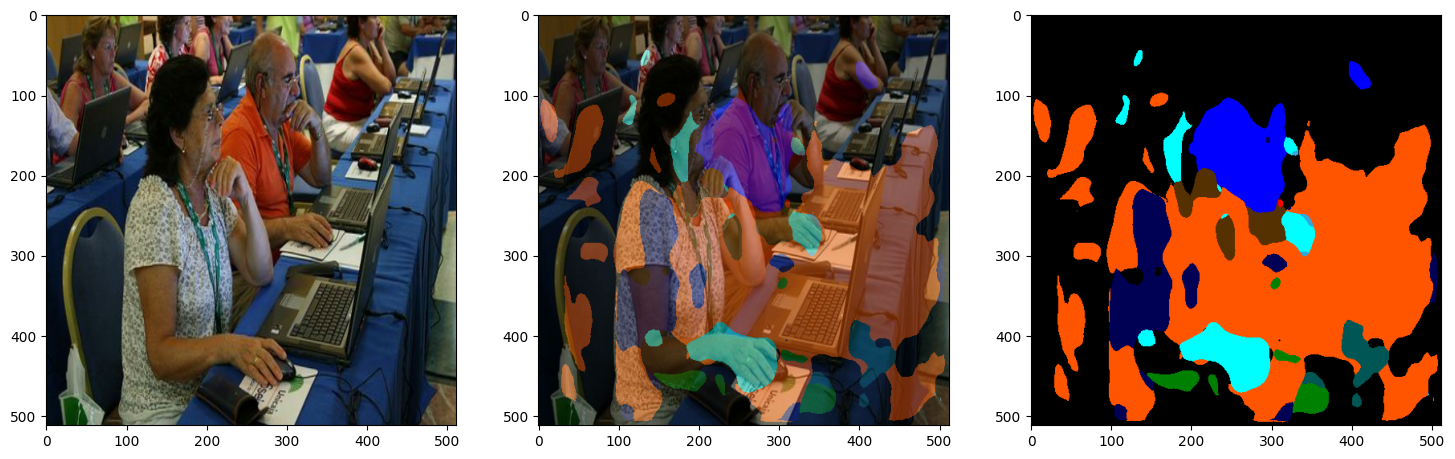

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


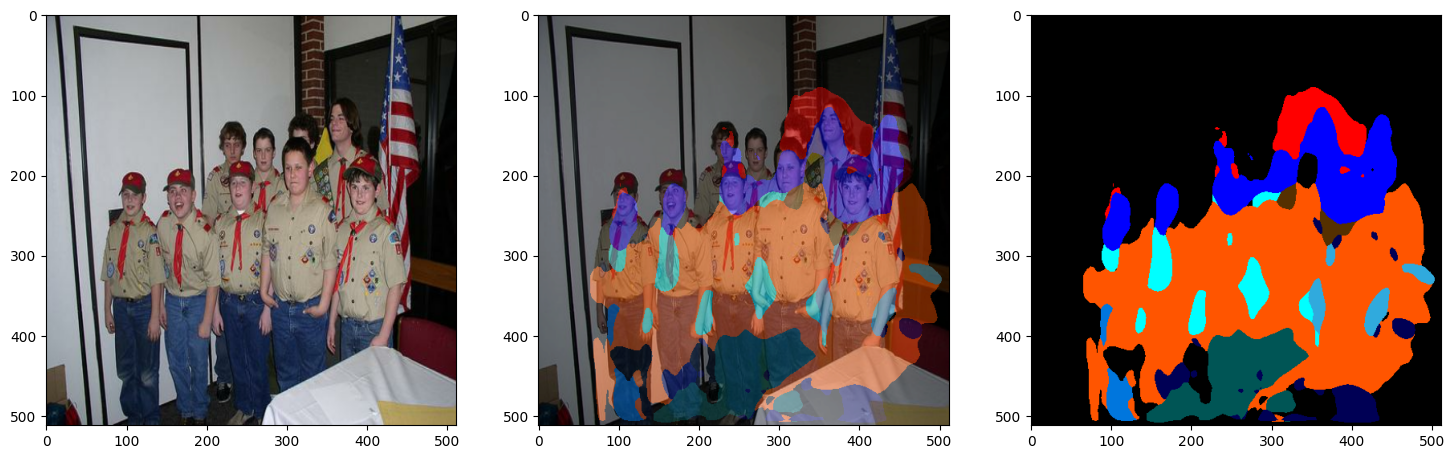

In [14]:
plot_predictions(val_images[:4], colormap, model=model)
